In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

We create a data frame with the time series containing the hourly values of the NO2 concentrations. Then we make a brief statistical analysis and we plot the time series:

In [2]:
NO2=pd.read_csv("NO2_E43.csv", index_col = "DATETIME")
NO2.rename(columns = {'mg/m^3_43':'mg/m^3'}, inplace = True)
NO2

,mg/m^3
DATETIME,
2019-07-01 01:00:00,33.0
2019-07-01 02:00:00,27.0
2019-07-01 03:00:00,25.0
2019-07-01 04:00:00,34.0
2019-07-01 05:00:00,21.0
...,...
2022-06-30 20:00:00,76.0
2022-06-30 21:00:00,30.0
2022-06-30 22:00:00,20.0


In [3]:
NO2.describe()

,mg/m^3
count,24945.000000
mean,39.769854
std,21.679772
min,1.000000
25%,23.000000
50%,36.000000
75%,53.000000
max,157.000000


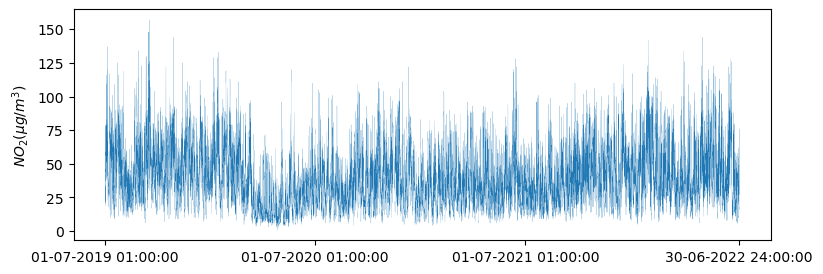

In [4]:
plt.figure(figsize=(9,3))
plt.plot(NO2["mg/m^3"],linewidth=.1)
plt.xticks(ticks=[0,8568,17160,25895],labels =["01-07-2019 01:00:00","01-07-2020 01:00:00","01-07-2021 01:00:00","30-06-2022 24:00:00"])
#plt.title(r'Concentrations of $NO_2$ and $PM_{10}$ from 1 Jul 2019 to 1 Jul 2022 by 1h')
plt.ylabel(r'$NO_2(\mu g/m^3)$')

plt.savefig("Latex/figures/NO2raw.jpg")
plt.show()

# Missing values imputation

We compute the percentage of missing values and add a new column named _mg/m^3_im_ where we replace them with the mean of the time series.

In [5]:
# % of missing values
1-NO2.count()/len(NO2)

mg/m^3    0.036724
dtype: float64

In [6]:
NO2["mg/m^3_im"] = NO2["mg/m^3"].fillna(NO2["mg/m^3"].mean())
NO2.head()

,mg/m^3,mg/m^3_im
DATETIME,,
2019-07-01 01:00:00,33.0,33.0
2019-07-01 02:00:00,27.0,27.0
2019-07-01 03:00:00,25.0,25.0
2019-07-01 04:00:00,34.0,34.0
2019-07-01 05:00:00,21.0,21.0


# 24 h mean analysis

We add a new column _mg/m^3_im_24h_ with the mean of the 24 previous values of the series _mg/m^3_im_24h_:

In [7]:
NO2["mg/m^3_im_24h"] = np.nan

for j in range(23, len(NO2)):

    NO2[ "mg/m^3_im_24h"][j] = NO2["mg/m^3_im"][j-23:j+1].mean()
    
NO2.head(48)

,mg/m^3,mg/m^3_im,mg/m^3_im_24h
DATETIME,,,
2019-07-01 01:00:00,33.0,33.0,NaN
2019-07-01 02:00:00,27.0,27.0,NaN
2019-07-01 03:00:00,25.0,25.0,NaN
2019-07-01 04:00:00,34.0,34.0,NaN
2019-07-01 05:00:00,21.0,21.0,NaN
2019-07-01 06:00:00,22.0,22.0,NaN
2019-07-01 07:00:00,42.0,42.0,NaN
2019-07-01 08:00:00,73.0,73.0,NaN
2019-07-01 09:00:00,79.0,79.0,NaN


We create a new time series _N02_00_ which contains the mean value of NO2 of every day:

In [8]:
NO2_00=NO2.loc[[x for x in NO2.index if x[-8:]=='00:00:00']]

In [9]:
ind=[]

for j in NO2_00.index:
    ind.append(j[:10])

ind

NO2_00.set_axis(ind, axis='index', inplace=True)

NO2_00= NO2_00["mg/m^3_im_24h"]
NO2_00= NO2_00.to_frame()
NO2_00

,mg/m^3_im_24h
2019-07-02,47.375000
2019-07-03,62.541667
2019-07-04,69.304565
2019-07-05,62.375000
2019-07-06,63.849541
...,...
2022-06-27,22.875000
2022-06-28,30.833333
2022-06-29,26.958333
2022-06-30,38.000000


We plot the 24h mean values and we indicate the AQG level and Interim stages:

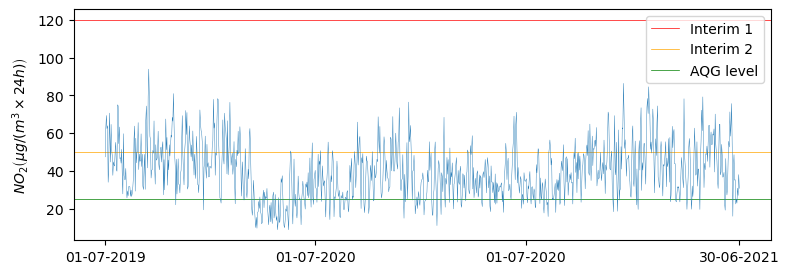

In [10]:
plt.figure(figsize=(9,3))

#plt.rcParams['text.usetex'] = True
plt.axhline(y=120, color ='red',linewidth=.5, label = "Interim 1")
plt.axhline(y=50, color ='orange',linewidth=.5, label = "Interim 2")
plt.axhline(y=25, color ='green',linewidth=.5, label = "AQG level" )
plt.plot(NO2_00["mg/m^3_im_24h"],linewidth=.3)
plt.xticks(ticks=[0, 357, 357+358, 357+358+363], labels =["01-07-2019","01-07-2020","01-07-2020","30-06-2021"])
#plt.title('24h mean of $NO_2$ concentrations from 2 Jul 2019 to 1 Jul 2022')
plt.ylabel(r'$NO_2\left(\mu g/(m^3\times 24 h)\right)$')
#plt.ylabel('NO2(mg/(m3 x 24h))')


plt.legend(loc = "upper right")
plt.savefig("Latex/figures/NO2_24mean.jpg")
plt.show()

We create a new column named _AQG_ which quantifies on which AQ stage is every value:

In [11]:
def AQG(x):
    if x<= 25:
        aqg = "+"
    elif 25<x<=50:
        aqg = "I1"
    elif 50<x<=120:
        aqg = "I2"
    elif x>120:
        aqg = "-"
    else:
        aqg = "NA"
    
    return aqg

NO2_00["AQG"]=NO2_00["mg/m^3_im_24h"].map(AQG)

In [12]:
q1907_1910 = NO2_00[NO2_00.index<"2019-11"]["AQG"]
q1911_2002 = NO2_00[("2019-10"< NO2_00.index)&(NO2_00.index<"2020-03")]["AQG"]

q2003_2006 = NO2_00[("2020-02"< NO2_00.index)&(NO2_00.index<"2020-07")]["AQG"]
q2007_2010 = NO2_00[("2020-06"< NO2_00.index)&(NO2_00.index<"2020-11")]["AQG"]
q2011_2102 = NO2_00[("2020-10"< NO2_00.index)&(NO2_00.index<"2021-03")]["AQG"]

q2103_2106 = NO2_00[("2021-02"< NO2_00.index)&(NO2_00.index<"2021-07")]["AQG"]
q2107_2110 = NO2_00[("2021-06"< NO2_00.index)&(NO2_00.index<"2021-11")]["AQG"]
q2111_2202 = NO2_00[("2021-10"< NO2_00.index)&(NO2_00.index<"2022-03")]["AQG"]

q2203_2206 = NO2_00[("2022-02"< NO2_00.index)]["AQG"]

In [13]:
#data = {'24h1907-1910': h1907_1910,'24h1911-2002': h1911_2002,
#        '24h2003-2006': h2003_2006,'24h2007-2010': h2007_2010,'24h2011-2102': h2011_2102,
#        '24h2103-2106': h2103_2106,'24h2107-2110': h2107_2110,'24h2111-2202': h2111_2202,
#        '24h2203#-2206': h2203_2206       
#       }
 

#per24h = pd.DataFrame(data)
#per24h=per24h.fillna(0)  

#per24h

We quantify which percentage of days have been on every stage divided by four month periods:

In [14]:
h1907_1910 = NO2_00[NO2_00.index<"2019-11"]["AQG"].value_counts()/len(NO2_00[NO2_00.index<"2019-11"]["AQG"])*100
h1911_2002 = NO2_00[("2019-10"< NO2_00.index)&(NO2_00.index<"2020-03")]["AQG"].value_counts()/len(NO2_00[("2019-10"< NO2_00.index)&(NO2_00.index<"2020-03")]["AQG"])*100

h2003_2006 = NO2_00[("2020-02"< NO2_00.index)&(NO2_00.index<"2020-07")]["AQG"].value_counts()/len(NO2_00[("2020-02"< NO2_00.index)&(NO2_00.index<"2020-07")]["AQG"])*100
h2007_2010 = NO2_00[("2020-06"< NO2_00.index)&(NO2_00.index<"2020-11")]["AQG"].value_counts()/len(NO2_00[("2020-06"< NO2_00.index)&(NO2_00.index<"2020-11")]["AQG"])*100
h2011_2102 = NO2_00[("2020-10"< NO2_00.index)&(NO2_00.index<"2021-03")]["AQG"].value_counts()/len(NO2_00[("2020-10"< NO2_00.index)&(NO2_00.index<"2021-03")]["AQG"])*100

h2103_2106 = NO2_00[("2021-02"< NO2_00.index)&(NO2_00.index<"2021-07")]["AQG"].value_counts()/len(NO2_00[("2021-02"< NO2_00.index)&(NO2_00.index<"2021-07")]["AQG"])*100
h2107_2110 = NO2_00[("2021-06"< NO2_00.index)&(NO2_00.index<"2021-11")]["AQG"].value_counts()/len(NO2_00[("2021-06"< NO2_00.index)&(NO2_00.index<"2021-11")]["AQG"])*100
h2111_2202 = NO2_00[("2021-10"< NO2_00.index)&(NO2_00.index<"2022-03")]["AQG"].value_counts()/len(NO2_00[("2021-10"< NO2_00.index)&(NO2_00.index<"2022-03")]["AQG"])*100

h2203_2206 = NO2_00[("2022-02"< NO2_00.index)]["AQG"].value_counts()/len(NO2_00[("2022-02"< NO2_00.index)]["AQG"])*100


In [15]:
data = {'24h1907-1910': h1907_1910,'24h1911-2002': h1911_2002,
        '24h2003-2006': h2003_2006,'24h2007-2010': h2007_2010,'24h2011-2102': h2011_2102,
        '24h2103-2106': h2103_2106,'24h2107-2110': h2107_2110,'24h2111-2202': h2111_2202,
        '24h2203-2206': h2203_2206       
       }
 

per24h = pd.DataFrame(data)
per24h=per24h.fillna(0)  

per24h

,24h1907-1910,24h1911-2002,24h2003-2006,24h2007-2010,24h2011-2102,24h2103-2106,24h2107-2110,24h2111-2202,24h2203-2206
+,0.000000,3.378378,41.721854,22.666667,15.646259,14.000000,15.032680,4.0,7.947020
I1,58.974359,54.054054,46.357616,67.333333,68.707483,77.333333,68.627451,60.0,58.940397
I2,41.025641,42.567568,11.920530,10.000000,15.646259,8.666667,16.339869,36.0,33.112583


We resume the results in two bar charts the first contains the percentage of days with AQG level and the second contains the percentage of days with Interim levels:

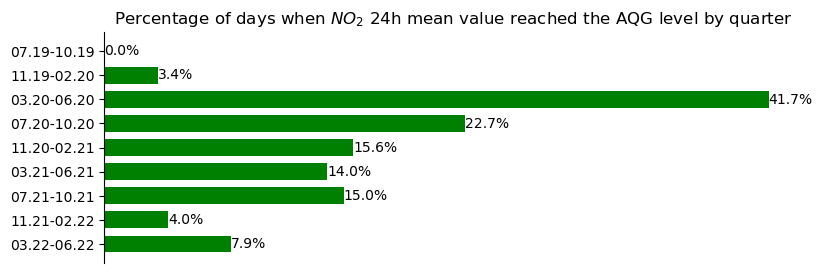

In [16]:

fig, ax = plt.subplots(figsize=(9,3))

x = ["07.19-10.19","11.19-02.20","03.20-06.20","07.20-10.20","11.20-02.21","03.21-06.21","07.21-10.21","11.21-02.22","03.22-06.22",]
p1=ax.barh(x,per24h.values[0],height =.7,label='AQG',color='green')

ax.bar_label(p1,fmt='%.1f%%')

#ax.set_ylabel('Time period')
ax.set_title(r'Percentage of days when $NO_2$ 24h mean value reached the AQG level by quarter')

plt.gca().invert_yaxis()

plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)


plt.savefig("Latex/figures/NO2_per1.jpg")
plt.show()

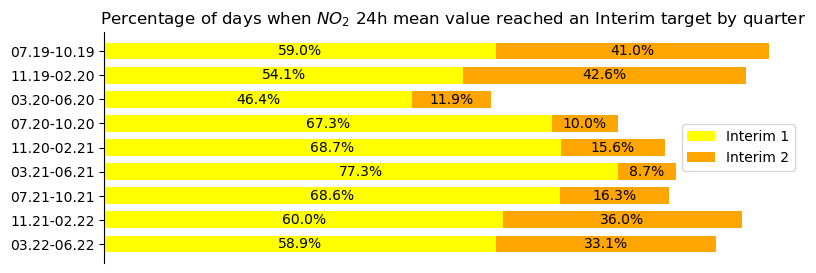

In [17]:
fig, ax = plt.subplots(figsize=(9,3))

x = ["07.19-10.19","11.19-02.20","03.20-06.20","07.20-10.20","11.20-02.21","03.21-06.21","07.21-10.21","11.21-02.22","03.22-06.22",]

p2=ax.barh(x,per24h.values[1],height =.7,label='Interim 1',color='yellow')
p3=ax.barh(x,per24h.values[2],height =.7,left=per24h.values[1],label='Interim 2',color='orange')

threshold = 0
for c in ax.containers:
    
    labels = [str(v.round(1))+'%' if v > threshold else "" for v in c.datavalues]    
    ax.bar_label(c,labels=labels, label_type="center")


#ax.set_ylabel('Time period')
ax.set_title(r'Percentage of days when $NO_2$ 24h mean value reached an Interim target by quarter')

plt.gca().invert_yaxis()
plt.legend()
plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig("Latex/figures/NO2_per2.jpg")
plt.show()

## 24 h train forecasting

We divide the time series in train and test set, we export the values to a csv for the ARIMA forecasting in R:

In [18]:
size = int(len(NO2["mg/m^3_im_24h"])*.8)

train_24, test_24 = NO2["mg/m^3_im_24h"].iloc[:size], NO2["mg/m^3_im_24h"].iloc[size:]

In [19]:
tr_NO2_24_00 = train_24.loc[[x for x in train_24.index if x[-8:]=='00:00:00']]
tr_NO2_24_00[1:].to_csv("tr_NO2_24h_00.csv")

te_NO2_24_00 = test_24.loc[[x for x in test_24.index if x[-8:]=='00:00:00']]
te_NO2_24_00.to_csv("te_NO2_24h_00.csv")

Read the NO2R.pdf file and then go back here.

After the forecasting has done in R we export the csv file with its values:

In [20]:
fr_NO2_24_00 =pd.read_csv("fr_N02_24H_00.csv")
fr_NO2_24_00

,Unnamed: 0,x
0,1,25.890750
1,2,24.989835
2,3,22.681917
3,4,43.983226
4,5,54.867590
...,...,...
211,212,35.267788
212,213,33.133753
213,214,37.141118
214,215,33.832667


We modify the dataframe _te_NO2_24_00_ on a way that it contains one column with the values of the test set and other with the values of the forecasting:

In [21]:
te_NO2_24_00=te_NO2_24_00.to_frame()
te_NO2_24_00["fr_mg/m^3_im_24h"]=''

for j in range(0,216):
    te_NO2_24_00["fr_mg/m^3_im_24h"][j]=fr_NO2_24_00["x"][j]

<ipython-input-21-7a833ee40537>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  te_NO2_24_00["fr_mg/m^3_im_24h"][j]=fr_NO2_24_00["x"][j]


In [22]:
ind=[]

for j in te_NO2_24_00.index:
    ind.append(j[:10])

ind

te_NO2_24_00.set_axis(ind, axis='index', inplace=True)
te_NO2_24_00

,mg/m^3_im_24h,fr_mg/m^3_im_24h
2021-11-28,25.916667,25.89075
2021-11-29,18.291667,24.989835
2021-11-30,47.458333,22.681917
2021-12-01,69.250000,43.983226
2021-12-02,40.583333,54.86759
...,...,...
2022-06-27,22.875000,35.267788
2022-06-28,30.833333,33.133753
2022-06-29,26.958333,37.141118
2022-06-30,38.000000,33.832667


We plot the forecast and test time series:

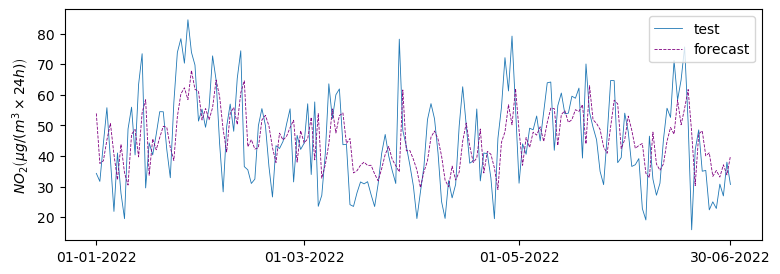

In [23]:
plt.figure(figsize=(9,3))
plt.plot(te_NO2_24_00["mg/m^3_im_24h"][35:],label="test", linewidth=.6)
plt.plot(te_NO2_24_00["fr_mg/m^3_im_24h"][35:],label="forecast",linewidth=.6 ,linestyle='--', color ='purple')


plt.xticks(ticks=[0,31+28,31+28+61,216-36],labels =["01-01-2022","01-03-2022","01-05-2022","30-06-2022"])
plt.ylabel(r'$NO_{2}\left(\mu g/(m^3\times 24 h)\right)$')

plt.legend(loc="upper right")
plt.savefig("Latex/figures/NO2_for.jpg")

plt.show()